Khám phá dữ liệu (exploratory data analysis)

In [1]:
# Thư viện

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import tensorflow as tf
from collections import Counter

In [2]:
# Thiết lập môi trường hiển thị

plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')
%matplotlib inline


In [3]:
# Đường dẫn đến các tập dữ liệu

base_dir = r"D:\MRI_4\dataset_3"
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


In [4]:
# danh sách các lớp
classes = ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]

In [5]:
# Hàm đếm số lượng ảnh trong mỗi lớp

def count_images_per_class(base_path):
    result = {}

    for class_name in classes:
        class_path = os.path.join(base_path, class_name)
        if os.path.exists(class_path):
            files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
            result[class_name] = len(files)
    return result


In [6]:
# đếm số lượng ảnh trong mỗi lớp cho các tập dữ liệu
train_counts = count_images_per_class(train_dir)
valid_counts = count_images_per_class(valid_dir)
test_counts = count_images_per_class(test_dir)

In [7]:
# Tạo df để hiển thị
df_counts = pd.DataFrame({
    'Train': train_counts,
    'Validation': valid_counts,
    'Test': test_counts
})

In [8]:
# Hiển thị số lượng ảnh trong mỗi lớp
print("Phân phối dữ liệu theo các lớp: ")
print(df_counts)
print(f"\n Tống số ảnh: {df_counts.sum().sum()}")
print(f"\n Tổng số ảnh trong tập train: {df_counts['Train'].sum()}")
print(f"\n Tổng số ảnh trong tập validation: {df_counts['Validation'].sum()}")
print(f"\n Tổng số ảnh trong tập test: {df_counts['Test'].sum()}")

Phân phối dữ liệu theo các lớp: 
            Train  Validation  Test
Glioma        564         161    80
Meningioma    358         124    63
No_Tumor      335          99    49
Pituitary     438         118    54

 Tống số ảnh: 2443

 Tổng số ảnh trong tập train: 1695

 Tổng số ảnh trong tập validation: 502

 Tổng số ảnh trong tập test: 246


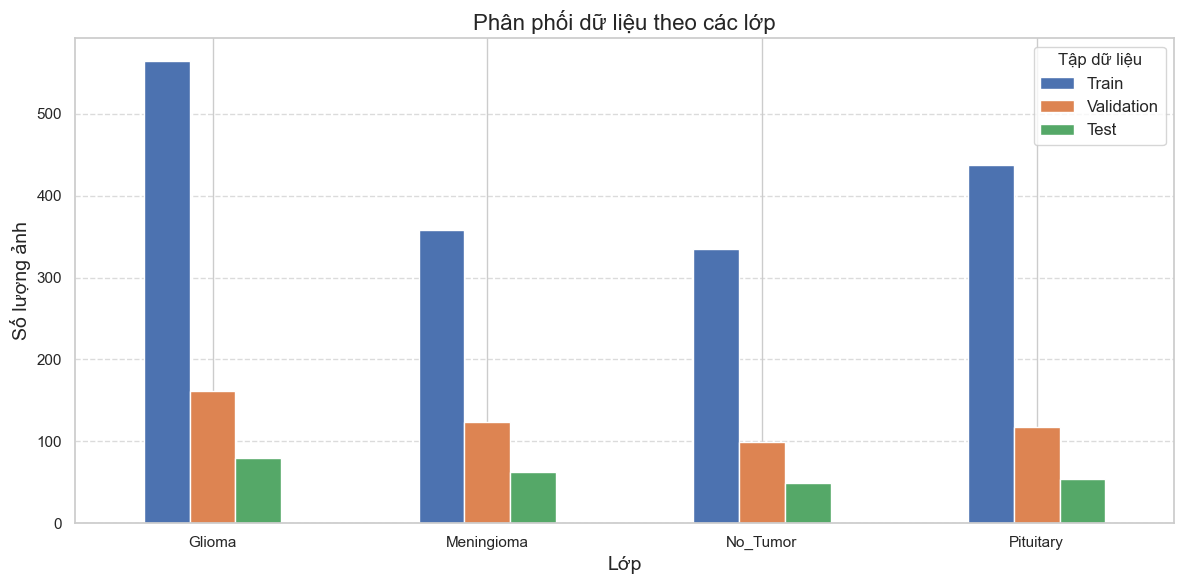

In [9]:
# Vẽ biểu đồ phân phối dữ liệu
plt.figure(figsize=(12, 6))
df_counts.plot(kind='bar', ax=plt.gca())
plt.title('Phân phối dữ liệu theo các lớp', fontsize=16)
plt.xlabel('Lớp', fontsize=14)
plt.ylabel('Số lượng ảnh', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Tập dữ liệu', fontsize=12)
plt.tight_layout()
plt.show()

Nhận xét:
tập train: glioma khá nhiều, chênh lệch nhiều
tập val: chênh ít hơn
tập test: khá đều

2. Phân tích kích thước ảnh và định dạng

In [10]:
# Hàm kiểm tra kích thước và kênh màu của ảnh
def analyze_image_properties(directory, num_samples = 10):
    image_sizes = []
    image_channels = []

    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if not os.path.exists(class_path):
            continue

        files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

        # lẫy mẫu ngẫu nhiên từ mỗi lớp
        sample_files = np.random.choice(files, min(num_samples, len(files)), replace=False)

        for file in sample_files:
            img_path = os.path.join(class_path, file)

            try:
                img = cv2.imread(img_path)
                if img is not None:
                    image_sizes.append(img.shape[:2])  # (height, width)
                    image_channels.append(img.shape[2] if len(img.shape) > 2 else 1)  # số kênh màu
                
            except Exception as e:
                print(f"Lỗi khi đọc ảnh {img_path}: {e}")

    return image_sizes, image_channels

In [12]:
# Phân tích thuộc tính của ảnh trong tập train
print("Phân tích thuộc tính của ảnh trong tập train:")
image_sizes_train, image_channels_train = analyze_image_properties(train_dir, num_samples=10)
print(f"Số lượng ảnh: {len(image_sizes_train)}")
print(f"Kích thước ảnh: {Counter(image_sizes_train)}")

Phân tích thuộc tính của ảnh trong tập train:
Số lượng ảnh: 40
Kích thước ảnh: Counter({(640, 640): 40})


In [13]:
# Hiển thị kích thước ảnh
unique_sizes_train = Counter(image_sizes_train).most_common()
print(f"\nKích thước ảnh phổ biến (số lượng): ")
for (height, width), count in unique_sizes_train:
    print(f"  {height}x{width}: {count} ảnh")




Kích thước ảnh phổ biến (số lượng): 
  640x640: 40 ảnh


In [14]:
# Hiển thị thông tin về số kênh màu
unique_channels_train = Counter(image_channels_train).most_common()
print(f"\nSố kênh màu phổ biến (số lượng): ")
for channels, count in unique_channels_train:
    print(f"  {channels} kênh: {count} ảnh")


Số kênh màu phổ biến (số lượng): 
  3 kênh: 40 ảnh


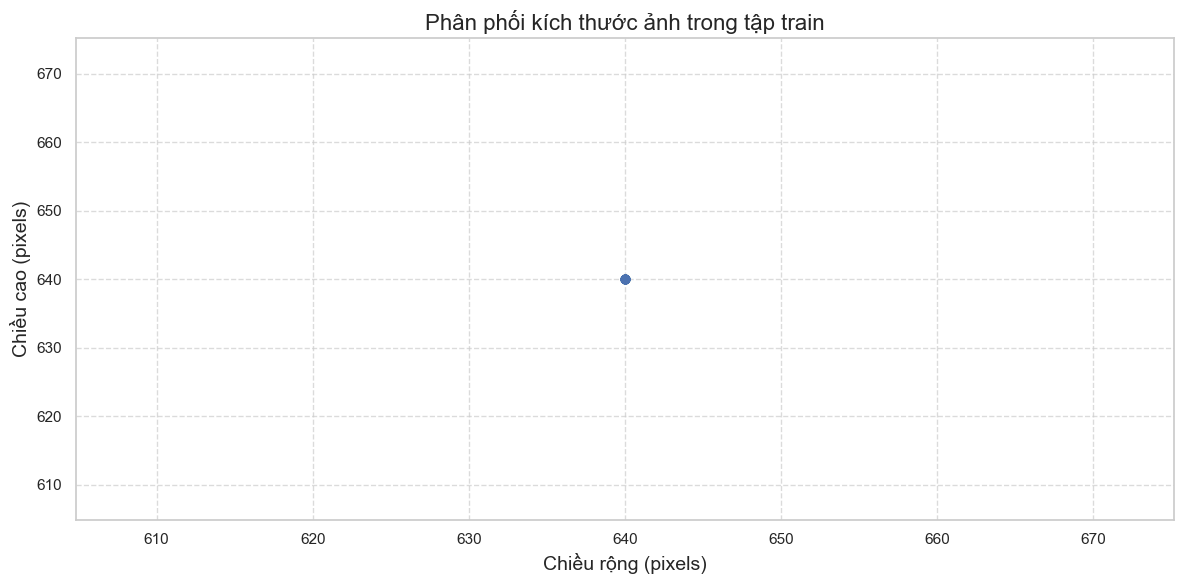

In [15]:
# Vẽ biểu đồ phân phối kích thước ảnh
plt.figure(figsize=(12, 6))
size_df = pd.DataFrame(image_sizes_train, columns=['Height', 'Width'])
plt.scatter(size_df['Width'], size_df['Height'], alpha=0.5)
plt.title('Phân phối kích thước ảnh trong tập train', fontsize=16)
plt.xlabel('Chiều rộng (pixels)', fontsize=14)
plt.ylabel('Chiều cao (pixels)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

3. Hiển thị 1 số ảnh từ mỗi lớp

Hiển thị mẫu ảnh từ tập train:


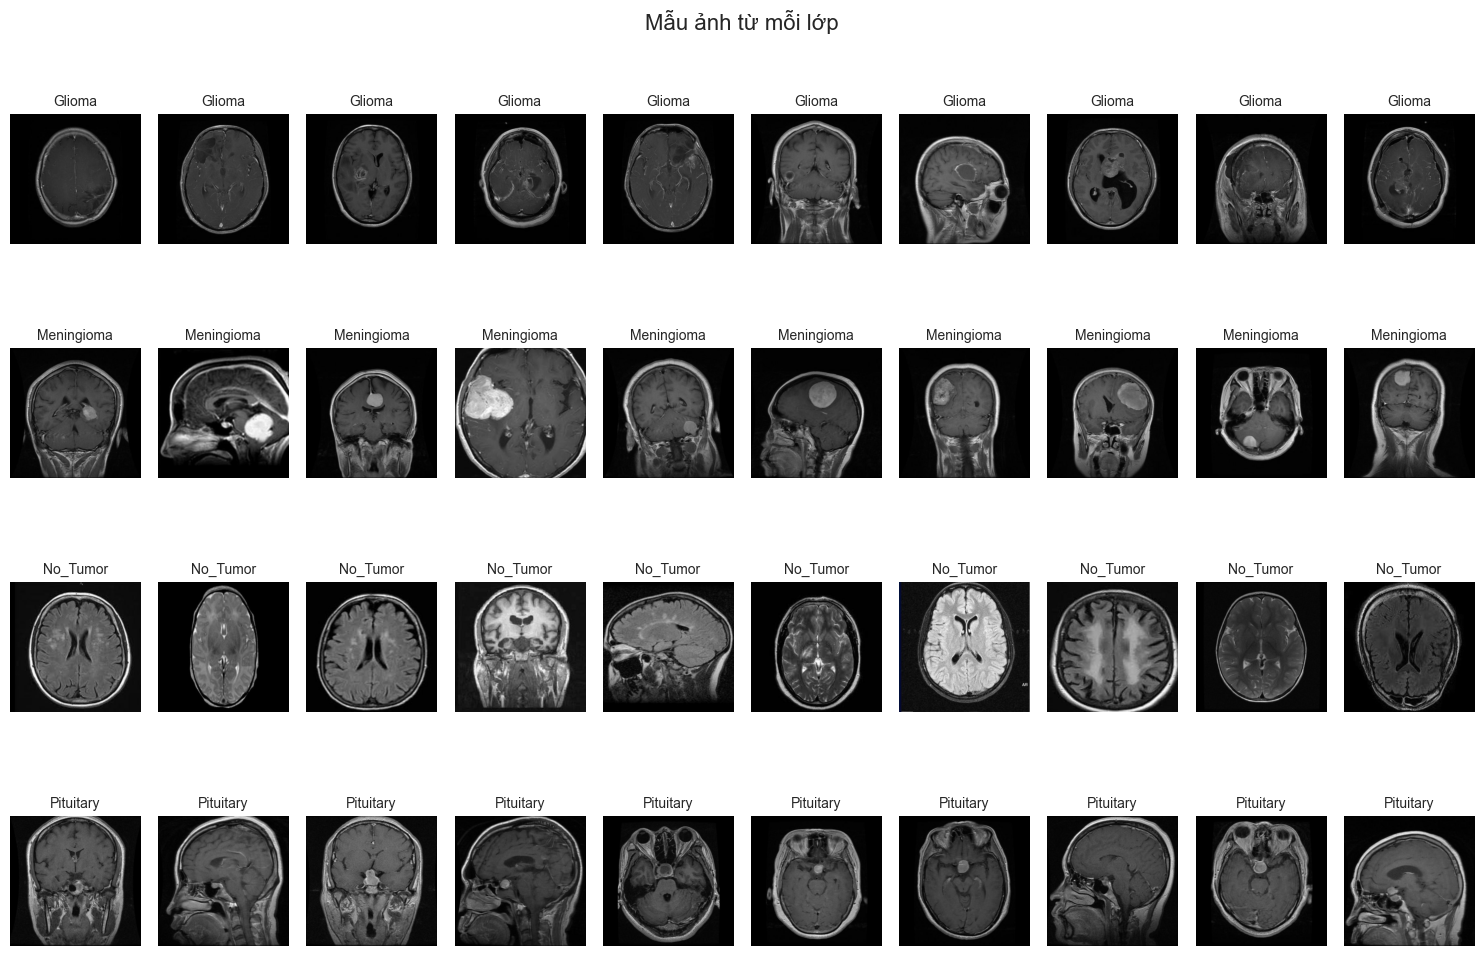

In [16]:
# Hàm để hiển thị 1 số ảnh từ mỗi lớp
def display_sample_images(directory, num_samples=10):
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        if not os.path.exists(class_path):
            countinue
        
        files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]    
        sample_files =np.random.choice(files, min(num_samples, len(files)), replace=False)

        for j, file in enumerate(sample_files):
            img_path = os.path.join(class_path, file)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
                    plt.imshow(img)
                    plt.title(f"{class_name}", fontsize=10)
                    plt.axis('off')
            except Exception as e:
                print(f"Lỗi khi đọc ảnh {img_path}: {e}")

    plt.tight_layout()
    plt.suptitle('Mẫu ảnh từ mỗi lớp', fontsize=16, y = 1.02)
    plt.show()

# Hiển thị mẫu ảnh từ tập train
print("Hiển thị mẫu ảnh từ tập train:")
display_sample_images(train_dir)

4. Phân tích độ sáng độ tương phản

In [19]:
# Hàm tính độ sáng và độ tương phản trung bình của ảnh
def analyze_brightness_contrast(directory, num_samples = 10):
    brightness_by_class = {class_name: [] for class_name in classes}
    contrast_by_class = {class_name: [] for class_name in classes}

    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if not os.path.exists(class_path):
            continue

        files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        sample_files = np.random.choice(files, min(num_samples, len(files)), replace=False)

        for file in sample_files:
            img_path = os.path.join(class_path, file)
            try:
                img = cv2.imread(img_path, 0)
                if img is not None:
                    brightness = np.mean(img)
                    brightness_by_class[class_name].append(brightness)

                    # Tính độ tương phản
                    constrast = np.std(img)
                    contrast_by_class[class_name].append(contrast)

            except Exception as e:
                print(f"Lỗi khi đọc ảnh {img_path}: {e}")

    return brightness_by_class, contrast_by_class




In [ ]:
# Phân tích độ sáng và độ tương phản của ảnh trong tập train
print("Phân tích độ sáng và độ tương phản của ảnh trong tập train.")
brightness_train, contrast_train = analyze_brightness_contrast(train_dir, num_samples=10)


C:\Users\buiva\AppData\Local\Temp\ipykernel_10740\3061487577.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([brightness_train[class_name] for class_name in classes], labels=classes)
C:\Users\buiva\AppData\Local\Temp\ipykernel_10740\3061487577.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([contrast_train[class_name] for class_name in classes], labels=classes)


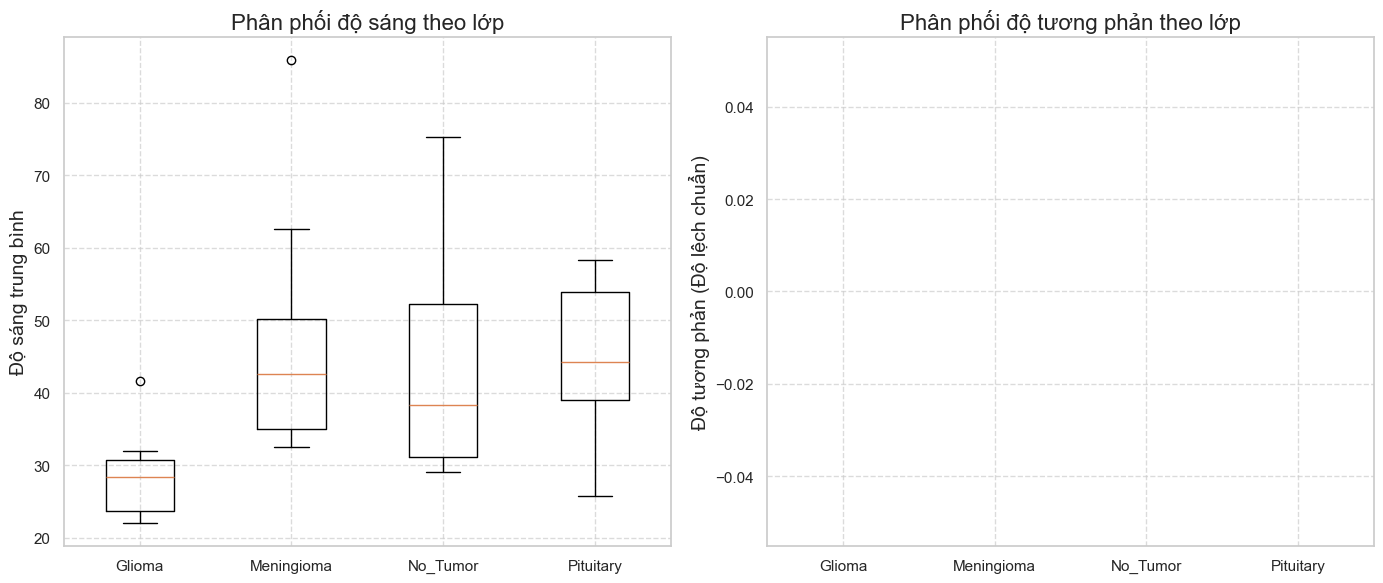

In [22]:
# Vẽ biểu đồ phân phối độ sáng
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.boxplot([brightness_train[class_name] for class_name in classes], labels=classes)
plt.title('Phân phối độ sáng theo lớp', fontsize=16)
plt.ylabel('Độ sáng trung bình', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.boxplot([contrast_train[class_name] for class_name in classes], labels=classes)
plt.title('Phân phối độ tương phản theo lớp', fontsize=16)
plt.ylabel('Độ tương phản (Độ lệch chuẩn)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

5. Trích xuất đặc trưng cơ bản

In [23]:
# Xây dựng model đơn giản để trích xuất đặc trưng
def extract_features(directory, num_samples = 25):
    # Sử dụng mobleNetV2 để trích xuất đặc trưng
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), 
        include_top=False, 
        weights='imagenet',
        pooling='avg'
    )
    features_by_class = {class_name: [] for class_name in classes}

    for class_name in classes:
        class_path = os.path.join(directory, class_name)

        if not os.path.exists(class_path):
            continue

        files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]    
        sample_files = np.random.choice(files, min(num_samples, len(files)), replace=False)

        for file in sample_files:
            img_path = os.path.join(class_path, file)
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
                img_array = np.expand_dims(img_array, axis=0)

                features = base_model.predict(img_array)
                features_by_class[class_name].append(features[0])
            except Exception as e:
                print(f"Lỗi khi đọc ảnh {img_path}: {e}")
            
    # Chuyển đổi danh sách thành mảng numpy
    for class_name in classes: 
        if features_by_class[class_name]:
            features_by_class[class_name] = np.array(features_by_class[class_name])
    
    return features_by_class




In [ ]:
# Trích xuất đặc trưng từ tập train 
print("Trích xuất đặc trưng từ tập train.")
features_train = extract_features(train_dir, num_samples=10)

In [ ]:
# Giảm chiều dữ liệu để hiển thị
from sklearn.decomposition import PCA